<a href="https://colab.research.google.com/github/ali-benny/CalcoloNumerico/blob/main/ProgettoFixCalcolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deblur Immagini
Il problema di deblur consiste nella ricostruzione di un immagine a partire da un dato acquisito mediante il seguente modello:

\begin{align*}
    b = A x + \eta
\end{align*}

dove $b$ rappresenta l'immagine corrotta, $x$ l'immagine originale che vogliamo ricostruire, $A$ l'operatore che applica il blur Gaussiano ed $\eta$ il rumore additivo con distribuzione Gaussiana di  media $\mathbb{0}$ e deviazione standard $\sigma$.

## Funzioni di blur
Le seguenti funzioni servono per applicare il blur di tipo gaussiano ad un'immagine.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, metrics
from scipy import signal
from numpy import fft

# Create a Gaussian kernel of size kernlen and standard deviation sigma
def gaussian_kernel(kernlen, sigma):
    x = np.linspace(- (kernlen // 2), kernlen // 2, kernlen)    
    # Unidimensional Gaussian kernel
    kern1d = np.exp(- 0.5 * (x**2 / sigma))
    # Bidimensional Gaussian kernel
    kern2d = np.outer(kern1d, kern1d)
    # Normalization
    return kern2d / kern2d.sum()

# Compute the FFT of the kernel 'K' of size 'd' padding with the zeros necessary
# to match the size of 'shape'
def psf_fft(K, d, shape):
    # Zero padding
    K_p = np.zeros(shape)
    K_p[:d, :d] = K

    # Shift
    p = d // 2
    K_pr = np.roll(np.roll(K_p, -p, 0), -p, 1)

    # Compute FFT
    K_otf = fft.fft2(K_pr)
    return K_otf

# Multiplication by A
def A(x, K):
  x = fft.fft2(x)
  return np.real(fft.ifft2(K * x))

# Multiplication by A transpose
def AT(x, K):
  x = fft.fft2(x)
  return np.real(fft.ifft2(np.conj(K) * x))

## Generazione dataset
Generare un set di 8 immagini 512$\times$512 in formato ${\tt png}$ in scala dei grigi che contengano tra i 2 ed i 6 oggetti geometrici, di colore uniforme, su sfondo nero. 


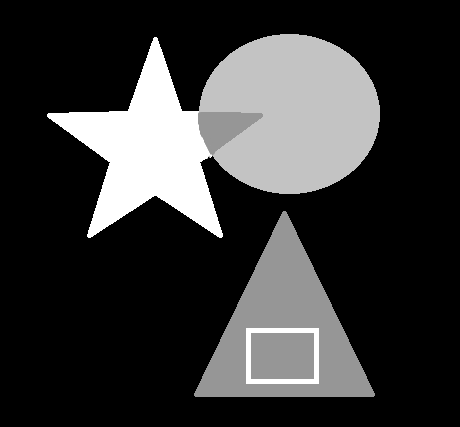


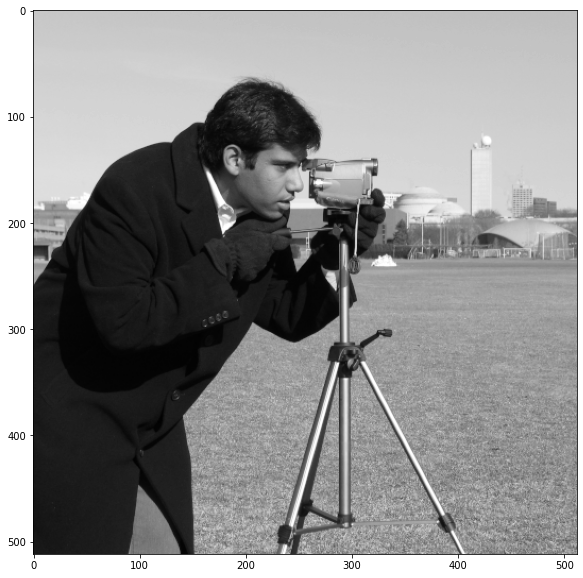

In [ ]:
from skimage.io import imread
from skimage import data
X = data.camera().astype(np.float64) / 255.0
#X = imread("./1.png", as_gray=True)
m, n = X.shape
x = X.reshape(m*n)
plt.figure(figsize=(30, 10))
plt.imshow(X, cmap="gray")

## 1) Generazione immagini corrotte
Degradare le immagini applicando, mediante le funzioni riportate nella cella precedente,  l'operatore di blur con parametri

+ $\sigma=0.5$ dimensione $5\times 5$
+ $\sigma=1$ dimensione $7\times 7$
+ $\sigma=1.3$ dimensione $9\times 9$

ed aggiungendo rumore gaussiano con deviazione standard $(0,0.05]$

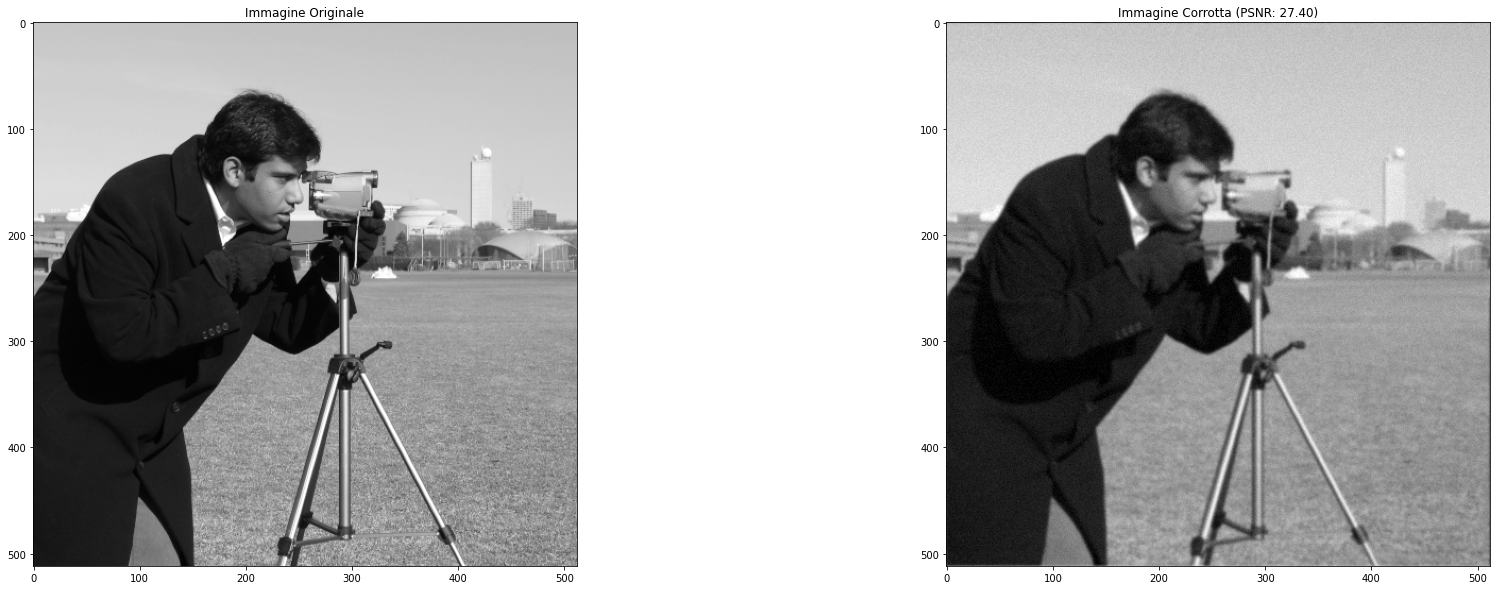

In [ ]:
K = psf_fft(gaussian_kernel(9, 1.3), 9, X.shape)

X_blur = A(X, K)
x_blur = X_blur.reshape(m*n)

std_dev = 0.02
noise = np.random.normal(size=X.shape)*std_dev

B = X_blur + noise
b = B.reshape(m*n)
#Maggiore è il valore del PSNR maggiore è la "somiglianza" con l'immagine originale,
#nel senso che si “avvicina” maggiormente ad essa da un punto di vista percettivo umano.
# => PSNR(X,X)=inf
PSNR = metrics.peak_signal_noise_ratio(X, B)

plt.figure(figsize=(30, 10))
plt.subplot(1, 2, 1).imshow(X, cmap='gray', vmin=0, vmax=1)
plt.title('Immagine Originale')

plt.subplot(1, 2, 2).imshow(B, cmap='gray', vmin=0, vmax=1)
plt.title(f'Immagine Corrotta (PSNR: {PSNR:.2f})')

plt.show()

## 2) Soluzione naive

Una possibile ricostruzione dell'immagine originale $x$ partendo dall'immagine corrotta $b$ è la soluzione naive data dal minimo del seguente problema di ottimizzazione:
\begin{align}
  x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2
\end{align}

La funzione $f$ da minimizzare è data dalla formula
  $f(x) = \frac{1}{2} ||Ax - b||_2^2 $, il cui gradiente $\nabla f$ è dato da
$\nabla f(x) = A^TAx - A^Tb  $.

Utilizzando il metodo del gradiente coniugato implementato dalla funzione `minimize` calcolare la soluzione naive. 

         Current function value: 39.194445
         Iterations: 6
         Function evaluations: 16
         Gradient evaluations: 16


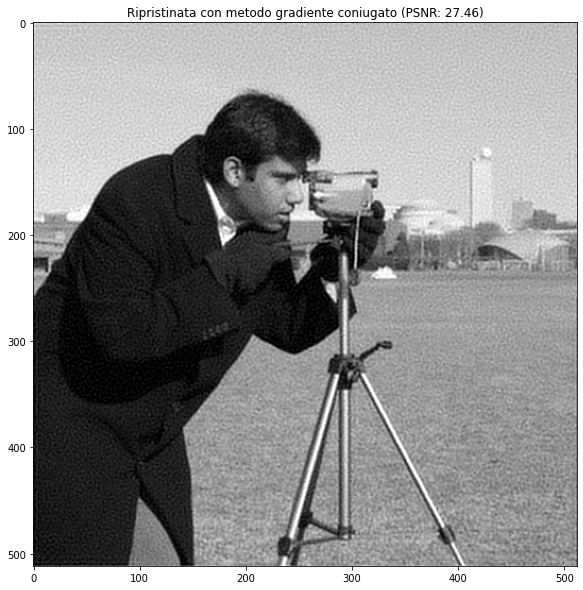

In [ ]:
from scipy.optimize import minimize
def f(x, labda = 0):
  X = x.reshape(m,n)
  res = 0.5*(np.linalg.norm(A(X, K)-B))**2 + 0.5*labda*(np.linalg.norm(X))**2
  return np.sum(res)
def df(x, labda=0):
  X = x.reshape(m,n)
  res = AT(A(X, K)-B, K) + labda*X
  RES = np.reshape(res, m*n)
  return RES

res = minimize(f, np.zeros(b.shape), method="CG", jac=df, options={'disp': True, 'maxiter':6})
RES = res.x.reshape(m,n)

PSNR = metrics.peak_signal_noise_ratio(X, RES)
plt.figure(figsize=(30,10))
plt.title(f'Ripristinata con metodo gradiente coniugato (PSNR: {PSNR:.2f})')

plt.imshow(RES, cmap="gray", vmin=0, vmax=1)


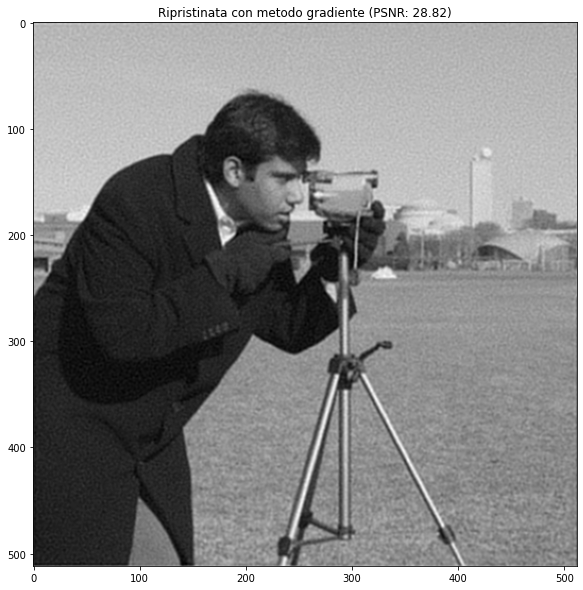

In [ ]:
def next_step(x, grad, labda = 0): # backtracking procedure for the choice of the steplength
  alpha=1.1
  c1 = 0.25
  p=-grad
  j=0
  jmax=10
  #condizioni che servono per soddisfare dei criteri di convergenza - condizioni di Wolfe
  while ((f(x + alpha*p, labda) > f(x, labda)+c1*alpha*grad.T@p) and j<jmax):
    alpha = alpha*0.5
    j+=1
  return alpha

def gradient_minimize(labda= 0, maxit=10, abstop = 1.e-6):
  x_last =np.zeros(m*n)
  k = 0
  while (np.linalg.norm(df(x_last, labda))>abstop and k < maxit):
    k=k+1
    grad = df(x_last, labda)
    step = next_step(x_last, grad, labda)
    x_last=x_last-step*grad
  return x_last
x_naive = gradient_minimize()
PSNR = metrics.peak_signal_noise_ratio(X, x_naive.reshape(m,n))
plt.figure(figsize=(30,10))
plt.title(f'Ripristinata con metodo gradiente (PSNR: {PSNR:.2f})')
plt.imshow(x_naive.reshape(m,n), cmap="gray")

## 3) Regolarizzazione
Per ridurre gli effetti del rumore nella ricostruzione è necessario introdurre un termine di regolarizzazione di Tikhonov. Si considera quindi il seguente problema di ottimizzazione.
\begin{align*}
  x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 + \frac{\lambda}{2} ||x||_2^2
\end{align*}

La funzione $f$ da minimizzare diventa
$f(x) = \frac{1}{2} ||Ax - b||_2^2 + \frac{\lambda}{2} ||x||_2^2$
il cui gradiente $\nabla f$ è dato da
$\nabla f(x) = A^TAx - A^Tb + λx$.

Utilizzando il metodo del gradiente coniugato implementato dalla funzione `minimize` ed il metodo del gradiente implementato a lezione, calcolare la soluzione del precendente problema di minimo regolarizzato per differenti valori di $\lambda$. 

In [ ]:
labda = list(np.linspace(1e-5, 1e-1, 100))

for i in range(100):
  func = lambda x: f(x, labda[i])
  grad_func = lambda x: df(x, labda[i])
  res = minimize(func, np.zeros(b.shape), method="CG", jac=grad_func, options={'disp': True, 'maxiter':6})
  RES = res.x.reshape(m,n)

  PSNR = metrics.peak_signal_noise_ratio(X, RES)
  print(f'lambda: {labda[i]} PSNR: {PSNR:.2f}')

         Current function value: 39.639750
         Iterations: 6
         Function evaluations: 16
         Gradient evaluations: 16
lambda: 1e-05 PSNR: 27.46


In [ ]:
labda = list(np.linspace(1e-5, 1e-1, 100))
maxi = -999999
for i in range(50):
  x_tikhonov = gradient_minimize(labda[i])
  PSNR = metrics.peak_signal_noise_ratio(X, x_tikhonov.reshape(m,n))
  maxi = max(maxi, PSNR)
  print(f'lambda: {labda[i]} PSNR: {PSNR:.2f}')
print("\n\n\n" + str(maxi))

## 4) Variazione Totale (Facoltativo) 

Un altra funzione adatta come termine di regolarizzazione è la Variazione Totale. Data $u$ immagine di dimensioni $m\times n$ la variazione totale $TV$ di $u$ è definit come:
\begin{align*}
  TV(u) = \sum_i^n{\sum_j^m{\sqrt{||\nabla u(i, j)||_2^2 + \epsilon^2}}}
\end{align*}
Per calcolare il gradiente dell'immagine $\nabla u$ usiamo la funzione `np.gradient` che approssima la derivata per ogni pixel calcolando la differenza tra pixel adiacenti. I risultati sono due immagini della stessa dimensione dell'immagine in input, una che rappresenta il valore della derivata orizzontale `dx` e l'altra della derivata verticale `dy`. Il gradiente dell'immagine nel punto $(i, j)$ è quindi un vettore di due componenti, uno orizzontale contenuto in `dx` e uno verticale in `dy`.

Come nei casi precedenti il problema di minimo che si va a risolvere è il seguente:
\begin{align*}
  x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 + \lambda TV(u)
\end{align*}
il cui gradiente $\nabla f$ è dato da
\begin{align*}
\nabla f(x) = (A^TAx - A^Tb)  + \lambda \nabla TV(x)
\end{align*}

Utilizzando il metodo del gradiente implementato a lezione, calcolare la soluzione del precendente problema di minimo regolarizzato per differenti valori di $\lambda$. 


---
Per risolvere il problema di minimo è necessario anche calcolare il gradiente della variazione totale che è definito nel modo seguente
\begin{align*}
  \nabla TV(u) = -div\left(\frac{\nabla u}{\sqrt{||\nabla u||_2^2 + \epsilon^2}}\right)
\end{align*}

\begin{align*}
  div(F) = \frac{\partial F_x}{\partial x} + \frac{\partial F_y}{\partial y}
\end{align*}

$div(F)$ è la divergenza del campo vettoriale $F$, nel nostro caso $F$ ha due componenti dati dal gradiente dell'immagine $\nabla u$ scalato per il valore $ \frac{1}{\sqrt{||\nabla u||_2^2 + \epsilon^2}}$. Per calcolare la divergenza bisogna calcolare la derivata orizzontale $\frac{\partial F_x}{\partial x}$ della componente $x$ di $F$ e sommarla alla derivata verticale $\frac{\partial F_y}{\partial y}$ della componente $y$ di $F$. Per specificare in quale direzione calcolare la derivata con la funzione `np.gradient` utilizziamo il parametro `axis = 0` per l'orizzontale e `axis = 1` per la verticale.

In [ ]:
eps = 1e-2

# Variazione totale
def totvar(x):
  # Calcola il gradiente di x
  dx, dy = np.gradient(x)
  n2 = np.square(dx) + np.square(dy)

  # Calcola la variazione totale di x
  tv = np.sqrt(n2 + eps**2).sum()
  return tv

# Gradiente della variazione totale
def grad_totvar(x):
  # Calcola il numeratore della frazione
  dx, dy = np.gradient(x)

  # Calcola il denominatore della frazione
  n2 = np.square(dx) + np.square(dy)
  den = np.sqrt(n2 + eps**2)

  # Calcola le due componenti di F dividendo il gradiente per il denominatore
  Fx = dx / den
  Fy = dy / den

  # Calcola la derivata orizzontale di Fx 
  dFdx = np.gradient(Fx, axis=0)
  
  # Calcola la derivata verticale di Fy
  dFdy = np.gradient(Fy, axis=1)

  # Calcola la divergenza 
  div = (dFdx + dFdy)

  # Restituisci il valore del gradiente della variazione totale
  return -div

In [ ]:
def f_tv(x, labda):
  X = x.reshape(m,n)
  res = 0.5*(np.linalg.norm(A(X, K)-B))**2 + labda*totvar(X)
  return np.sum(res)
def df_tv(x, labda):
  X = x.reshape(m,n)
  res = AT(A(X, K)-B, K) + labda*grad_totvar(X)
  RES = np.reshape(res, m*n)
  return RES
def next_step_tv(x,grad, labda): # backtracking procedure for the choice of the steplength
  alpha=1.1
  c1 = 0.25
  p=-grad
  j=0
  jmax=10
  #condizioni che servono per soddisfare dei criteri di convergenza - condizioni di Wolfe
  while ((f_tv(x + alpha*p, labda) > f_tv(x, labda)+c1*alpha*grad.T@p) and j<jmax):
    alpha= alpha*0.5
    j+=1
  return alpha
def gradient_minimize_tv(labda, maxit=30, abstop = 1.e-6):
  x_last = x0=np.zeros(m*n)
  k = 0
  while (np.linalg.norm(df_tv(x_last, labda))>abstop and k < maxit):
    k=k+1
    grad = df_tv(x_last, labda)
    step = next_step_tv(x_last, grad, labda)
    x_last=x_last-step*grad
  return x_last

labda = list(np.linspace(0.00001, 0.5, 50))
for i in range(50):
  x_tv = gradient_minimize_tv(labda[i])
  PSNR = metrics.peak_signal_noise_ratio(X, x_tv.reshape(m,n))
  print(f'lambda: {labda[i]} PSNR: {PSNR:.2f}')
  plt.figure(figsize=(30,10))
  plt.title(f'Ripristinata con metodo gradiente (PSNR: {PSNR:.2f})')
  plt.imshow(x_tv.reshape(m,n), cmap="gray")

# Relazione

1.   Riportare e commentare i risultati ottenuti nei punti 2. 3. (e 4.) su un immagine del set creato e su altre due immagini in bianco e nero  (fotografiche/mediche/astronomiche)
2.   Riportare delle tabelle con le misure di PSNR e MSE ottenute al variare dei parametri (dimensione kernel, valore di sigma, la deviazione standard del rumore, il parametro di regolarizzazione). 
3. Calcolare sull’intero set di immagini medie e deviazione standard delle metriche per alcuni valori fissati dei parametri.  
4. Analizzare su 2 esecuzioni le proprietà dei metodi numerici utilizzati (gradiente coniugato e gradiente) in termini di numero di iterazioni, andamento dell’errore, della funzione obiettivo, norma del gradiente. 

